# Poputi — Survey Analysis

This notebook loads the exported survey answers, cleans duplicates (keeping the latest per `user_id` × `question_id`), normalizes time units to minutes, visualizes the scatter of base time vs acceptable extra time, and fits an approximate non-decreasing threshold function.

References and intent are based on `doc/definition.md` (Objective strategy): estimate a population threshold function f(x) mapping base time x to acceptable extra time δ_acc. We show a monotone approximation and a binned-quantile curve.


In [16]:
# Install dependencies (if needed)
import sys, subprocess, importlib

def ensure(pkg):
    try:
        importlib.import_module(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

for p in ["pandas", "numpy", "matplotlib", "seaborn", "scikit-learn", "patsy"]:
    ensure(p)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.isotonic import IsotonicRegression

pd.set_option("display.max_columns", 200)



Defaulting to user installation because normal site-packages is not writeable


In [17]:
from pathlib import Path

# Path to today's export (adjust if needed)
export_dir = Path('../survey/export/2025-09-17')
export_file = export_dir / 'survey_export.csv'
assert export_file.exists(), f"Export file not found: {export_file}"

raw = pd.read_csv(export_file)
print(raw.shape)
raw.head()


(817, 14)


,doc_id,user_id,lang,submitted_at,meta_Age,meta_Sex,meta_Education,meta_Country,question_id,means,base_time_value,base_time_unit,acceptable_extra_time,acceptable_extra_time_unit
0,0Zp5xBCPIYnUvKEXYJx3,u_mfo9t2ob_k1buxm,ru,2025-09-17T17:47:39.920Z,20.0,male,secondary,BY,7,car,30,minutes,19,minutes
1,0Zp5xBCPIYnUvKEXYJx3,u_mfo9t2ob_k1buxm,ru,2025-09-17T17:47:39.920Z,20.0,male,secondary,BY,46,car,25,minutes,20,minutes
2,0Zp5xBCPIYnUvKEXYJx3,u_mfo9t2ob_k1buxm,ru,2025-09-17T17:47:39.920Z,20.0,male,secondary,BY,214,bicycle,140,minutes,5,minutes
3,0Zp5xBCPIYnUvKEXYJx3,u_mfo9t2ob_k1buxm,ru,2025-09-17T17:47:39.920Z,20.0,male,secondary,BY,411,bicycle,55,minutes,5,minutes
4,0Zp5xBCPIYnUvKEXYJx3,u_mfo9t2ob_k1buxm,ru,2025-09-17T17:47:39.920Z,20.0,male,secondary,BY,517,car,2,hours,15,minutes


In [18]:
# Deduplicate by (user_id, question_id): keep latest submitted_at

def parse_dt(x):
    try:
        return pd.to_datetime(x, utc=True, errors='coerce')
    except Exception:
        return pd.NaT

# Ensure required columns
cols_needed = [
    'user_id', 'question_id', 'submitted_at',
    'base_time_value', 'base_time_unit',
    'acceptable_extra_time', 'acceptable_extra_time_unit'
]
missing = [c for c in cols_needed if c not in raw.columns]
print('Missing columns:', missing)

raw['submitted_at_dt'] = raw['submitted_at'].map(parse_dt)
raw_sorted = raw.sort_values(['user_id', 'question_id', 'submitted_at_dt'], ascending=[True, True, True])

dedup = raw_sorted.drop_duplicates(subset=['user_id', 'question_id'], keep='last').copy()
print('After dedup:', dedup.shape)
dedup.head()


Missing columns: []
After dedup: (389, 15)


,doc_id,user_id,lang,submitted_at,meta_Age,meta_Sex,meta_Education,meta_Country,question_id,means,base_time_value,base_time_unit,acceptable_extra_time,acceptable_extra_time_unit,submitted_at_dt
147,Hhr2m0b2d3SuclfIgHd5,u_mfn1rnpn_mh9bfx,ru,2025-09-16T21:15:43.648Z,21.0,male,higher,BY,81,bicycle,4,hours,25,minutes,2025-09-16 21:15:43.648000+00:00
148,Hhr2m0b2d3SuclfIgHd5,u_mfn1rnpn_mh9bfx,ru,2025-09-16T21:15:43.648Z,21.0,male,higher,BY,177,walk,25,minutes,5,minutes,2025-09-16 21:15:43.648000+00:00
149,Hhr2m0b2d3SuclfIgHd5,u_mfn1rnpn_mh9bfx,ru,2025-09-16T21:15:43.648Z,21.0,male,higher,BY,376,bicycle,25,minutes,5,minutes,2025-09-16 21:15:43.648000+00:00
150,Hhr2m0b2d3SuclfIgHd5,u_mfn1rnpn_mh9bfx,ru,2025-09-16T21:15:43.648Z,21.0,male,higher,BY,518,walk,115,minutes,20,minutes,2025-09-16 21:15:43.648000+00:00
151,Hhr2m0b2d3SuclfIgHd5,u_mfn1rnpn_mh9bfx,ru,2025-09-16T21:15:43.648Z,21.0,male,higher,BY,600,bicycle,20,minutes,5,minutes,2025-09-16 21:15:43.648000+00:00


In [19]:
# Normalize to minutes

UNIT_TO_MIN = {
    'minutes': 1.0,
    'minute': 1.0,
    'm': 1.0,
    'hours': 60.0,
    'hour': 60.0,
    'h': 60.0,
    'days': 24.0*60.0,
    'day': 24.0*60.0,
    'd': 24.0*60.0,
}

for col_val, col_unit, out_col in [
    ('base_time_value', 'base_time_unit', 'base_minutes'),
    ('acceptable_extra_time', 'acceptable_extra_time_unit', 'extra_minutes'),
]:
    vals = pd.to_numeric(dedup[col_val], errors='coerce')
    units = dedup[col_unit].astype(str).str.lower().str.strip()
    scale = units.map(UNIT_TO_MIN).astype(float)
    dedup[out_col] = vals * scale

clean = dedup.dropna(subset=['base_minutes', 'extra_minutes']).copy()
# remove negative and unrealistic
clean = clean[(clean['base_minutes'] >= 0) & (clean['extra_minutes'] >= 0)]
print(clean[['base_minutes','extra_minutes']].describe())
clean.head()


       base_minutes  extra_minutes
count    389.000000     389.000000
mean     109.280206      24.110540
std      353.647410      49.141397
min       10.000000       0.000000
25%       20.000000      10.000000
50%       50.000000      15.000000
75%      110.000000      20.000000
max     4320.000000     720.000000


,doc_id,user_id,lang,submitted_at,meta_Age,meta_Sex,meta_Education,meta_Country,question_id,means,base_time_value,base_time_unit,acceptable_extra_time,acceptable_extra_time_unit,submitted_at_dt,base_minutes,extra_minutes
147,Hhr2m0b2d3SuclfIgHd5,u_mfn1rnpn_mh9bfx,ru,2025-09-16T21:15:43.648Z,21.0,male,higher,BY,81,bicycle,4,hours,25,minutes,2025-09-16 21:15:43.648000+00:00,240.0,25.0
148,Hhr2m0b2d3SuclfIgHd5,u_mfn1rnpn_mh9bfx,ru,2025-09-16T21:15:43.648Z,21.0,male,higher,BY,177,walk,25,minutes,5,minutes,2025-09-16 21:15:43.648000+00:00,25.0,5.0
149,Hhr2m0b2d3SuclfIgHd5,u_mfn1rnpn_mh9bfx,ru,2025-09-16T21:15:43.648Z,21.0,male,higher,BY,376,bicycle,25,minutes,5,minutes,2025-09-16 21:15:43.648000+00:00,25.0,5.0
150,Hhr2m0b2d3SuclfIgHd5,u_mfn1rnpn_mh9bfx,ru,2025-09-16T21:15:43.648Z,21.0,male,higher,BY,518,walk,115,minutes,20,minutes,2025-09-16 21:15:43.648000+00:00,115.0,20.0
151,Hhr2m0b2d3SuclfIgHd5,u_mfn1rnpn_mh9bfx,ru,2025-09-16T21:15:43.648Z,21.0,male,higher,BY,600,bicycle,20,minutes,5,minutes,2025-09-16 21:15:43.648000+00:00,20.0,5.0


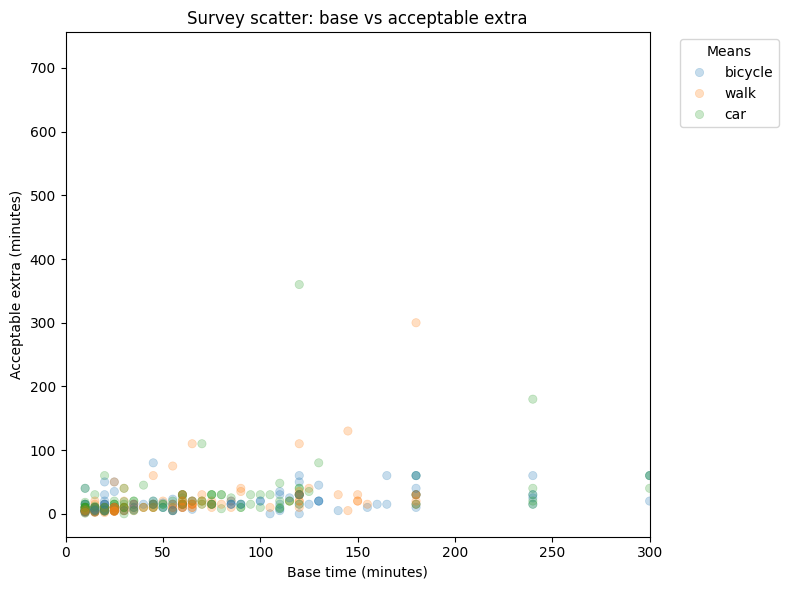

In [20]:
# Scatter plot (limit view to ~300 minutes on x-axis)
plt.figure(figsize=(8,6))
sns.scatterplot(data=clean, x='base_minutes', y='extra_minutes', hue='means', alpha=0.25, edgecolor=None)
plt.xlabel('Base time (minutes)')
plt.ylabel('Acceptable extra (minutes)')
plt.title('Survey scatter: base vs acceptable extra')
plt.legend(title='Means', bbox_to_anchor=(1.04, 1), loc='upper left')
plt.xlim(0, 300)
plt.tight_layout()
plt.show()


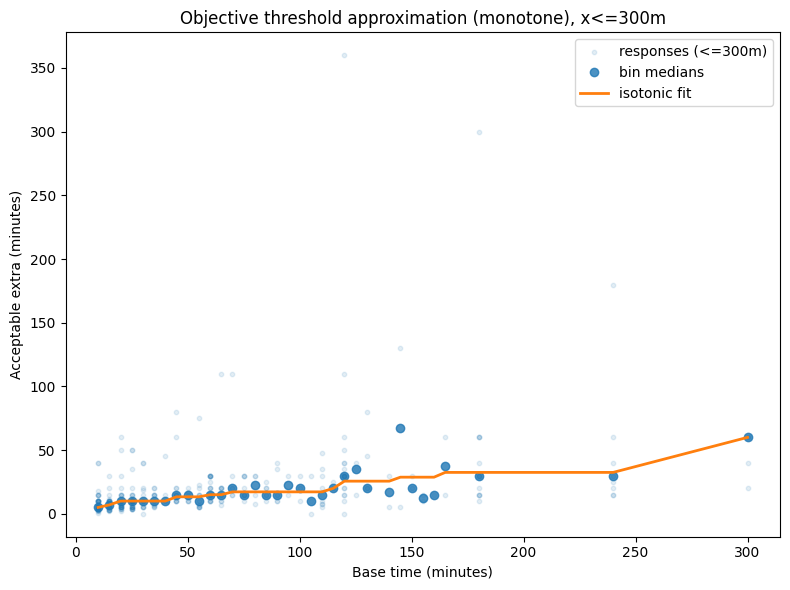

Sample of fitted points:


,x_minutes,fitted_extra_minutes
0,10.0,5.000000
1,15.0,7.000000
2,20.0,10.000000
3,25.0,10.000000
4,30.0,10.000000
5,35.0,10.000000
6,40.0,10.000000
7,45.0,13.333333
8,50.0,13.333333
9,55.0,13.333333


In [21]:
# Approximate non-decreasing function using isotonic regression on binned medians

# Limit to <=300 minutes for fitting/plotting view
clean_fit = clean[clean['base_minutes'] <= 300].copy()

# Bin base_minutes to reduce noise
bins = np.linspace(clean_fit['base_minutes'].min(), clean_fit['base_minutes'].max(), 60)
clean_fit['bin'] = pd.cut(clean_fit['base_minutes'], bins, include_lowest=True)

agg = clean_fit.groupby('bin', observed=True).agg(
    x=('base_minutes', 'median'),
    y=('extra_minutes', 'median'),
    n=('extra_minutes', 'size')
).dropna()

# Fit isotonic (monotone increasing)
iso = IsotonicRegression(increasing=True, out_of_bounds='clip')
fit_y = iso.fit_transform(agg['x'].values, agg['y'].values)

plt.figure(figsize=(8,6))
plt.scatter(clean_fit['base_minutes'], clean_fit['extra_minutes'], s=10, alpha=0.12, label='responses (<=300m)')
plt.plot(agg['x'].values, agg['y'].values, 'o', label='bin medians', alpha=0.8)
plt.plot(agg['x'].values, fit_y, '-', lw=2, label='isotonic fit')
plt.xlabel('Base time (minutes)')
plt.ylabel('Acceptable extra (minutes)')
plt.title('Objective threshold approximation (monotone), x<=300m')
plt.legend()
plt.tight_layout()
plt.show()

print('Sample of fitted points:')
pd.DataFrame({'x_minutes': agg['x'].values, 'fitted_extra_minutes': fit_y}).head(10)


In [22]:
# Export fitted curve for cross-language use
# 1) CSV of (x, y)
# 2) JSON piecewise-linear representation with breakpoints and values
from pathlib import Path
import json

out_dir = Path('.')
out_dir.mkdir(parents=True, exist_ok=True)

export_df = pd.DataFrame({
    'x_minutes': agg['x'].values.astype(float),
    'fitted_extra_minutes': fit_y.astype(float)
})

csv_path = out_dir / 'fitted_threshold.csv'
export_df.to_csv(csv_path, index=False)
print(f"Wrote fitted curve CSV to: {csv_path}")

json_path = out_dir / 'fitted_threshold.json'
rep = {
    'representation': 'piecewise_linear',
    'units': {'x': 'minutes', 'y': 'minutes'},
    'breakpoints': export_df['x_minutes'].tolist(),
    'values': export_df['fitted_extra_minutes'].tolist(),
    'interp': 'linear',
    'monotone': True,
}
json_path.write_text(json.dumps(rep, ensure_ascii=False, indent=2), encoding='utf-8')
print(f"Wrote fitted curve JSON to: {json_path}")
export_df.head()


Wrote fitted curve CSV to: fitted_threshold.csv
Wrote fitted curve JSON to: fitted_threshold.json


,x_minutes,fitted_extra_minutes
0,10.0,5.0
1,15.0,7.0
2,20.0,10.0
3,25.0,10.0
4,30.0,10.0
